In [1]:
# Boilerplate at top of file
%load_ext autoreload

%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
from ggplot import *


### Custom
import nltk
import sys
sys.path.append('../')
import cleaner
from feature_eng import FeatureFactory
import random

Loading global tagger... please wait a few seconds


In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

from sklearn.linear_model import LinearRegression,  Lasso, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

In [3]:
ff = FeatureFactory(set_params=False)

In [60]:
def rmse(clf, x, y): 
    return mean_squared_error(clf.predict(x), y)**0.5
def rmse_score(clf, x, y): 
    # grid search does maximization
    return -mean_squared_error(clf.predict(x), y)**0.5

In [61]:
df_train_full = pd.read_csv('../data/train_features/train_features_full.csv')

# smaller ssample size for test_purposes

df_train = df_train_full


In [62]:
df_train = df_train.iloc[random.sample(df_train.index,2000)].reset_index()



In [25]:
# df_train= pd.read_csv('../data/train_sample_features.csv')

In [26]:
df_train = pd.read_csv('../data/esa_features_sample.csv')
df_train = df_train.fillna(0)

In [69]:
## Constants
Y_KEY = 'relevance'
feat_cols = ff.get_feature_names()
feat_cols = feat_cols + ['ESA_0', 'ESA_025', 'ESA_05', 'ESA_075', 'ESA_Max', 'Is_High_ESA']

In [28]:
# from itertools import combinations
# list(combinations(feat_cols, 2))
# def generate_interaction_effects(df, feat_cols):
    
#     for col_0, col_1 in combinations(feat_cols, 2):
#         new_col = '%s_with_%s' % (col_0, col_1)
#         df[new_col] = np.multiply(df[col_0], df[col_1])
#         feat_cols.append(new_col)
#     return feat_cols
# feat_cols = generate_interaction_effects(df_train, feat_cols)        

In [29]:
def apse_k_fold(clfs, x, y, k = 10, 
                m_metric = lambda x,y : mean_squared_error(x,y)**0.5,
                verbose=False,
               feature_selection = lambda df, x_col, y_col: (np.array(df[x_col]), np.array(df[y_col]))
               ):
    # all uses the same folds
    # for RMSE
    n = len(y)

    X = np.array(x)
    y = np.array(y)

    print X.shape
    kf = KFold(n, n_folds=k)

#     X = np.array(df[x_col])
#     y = np.array(df[y_col])
    results = []
    for clf in clfs:
        if verbose:
            print '%s-Fold Cross Validation for %s' % (k, clf.__class__.__name__)
        fm = clone(clf).fit(X, y)
        apses = []
        varias =  []
        for train_index, test_index in kf:
        #     print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            fm_y_pred = fm.predict(X_test)
            var = m_metric(y_test, fm_y_pred)
            apse = m_metric(y_test, y_pred)
            apses.append(apse)
            varias.append(var)
#             mse = m_metric(fm_y_pred, y_)
            if verbose:
                print "APSE", apse, "Variance", var
        results.append(dict(
            classifier = clf.__class__.__name__,
            params = clf.get_params(),
            apse_mean = np.mean(apses),
            var_mean = np.mean(varias),
            ))
    return pd.DataFrame(results)
from sklearn.feature_selection import f_regression
def feature_selection(df, x_col, y_col):
    kbest = SelectKBest(f_regression, k=5)
    X =  kbest.fit_transform(df[x_col], df[y_col])
    Y = df[y_col]
    return X,Y

In [30]:
rf = RandomForestRegressor()
lm = LinearRegression()
lasso = LassoCV()
gbr = GradientBoostingRegressor()
bgr = BaggingRegressor()
knn = KNeighborsRegressor()
# apse_k_fold(rf, df_train, feat_cols, Y_KEY)


df_res = apse_k_fold(
    [rf, lm, lasso, gbr, bgr, knn], 
#     [svr],
    df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)
df_res

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.519790,RandomForestRegressor,"{u'warm_start': False, u'oob_score': False, u'...",0.215027
1,0.492522,LinearRegression,"{u'copy_X': True, u'normalize': False, u'n_job...",0.486069
2,0.498481,LassoCV,"{u'normalize': False, u'alphas': None, u'n_job...",0.494596
3,0.493383,GradientBoostingRegressor,"{u'warm_start': False, u'loss': u'ls', u'verbo...",0.427592
4,0.522113,BaggingRegressor,"{u'max_samples': 1.0, u'base_estimator': None,...",0.219755
5,0.562298,KNeighborsRegressor,"{u'n_neighbors': 5, u'algorithm': u'auto', u'm...",0.461652


# visualize

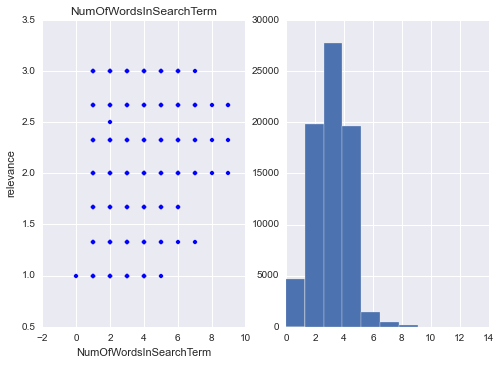

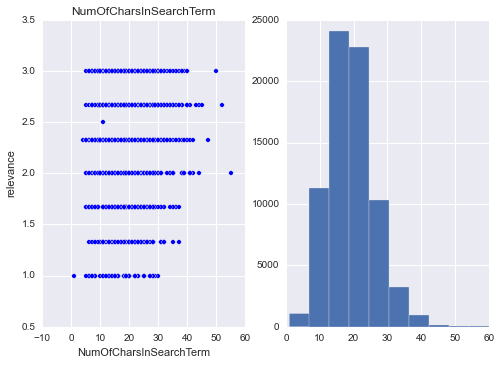

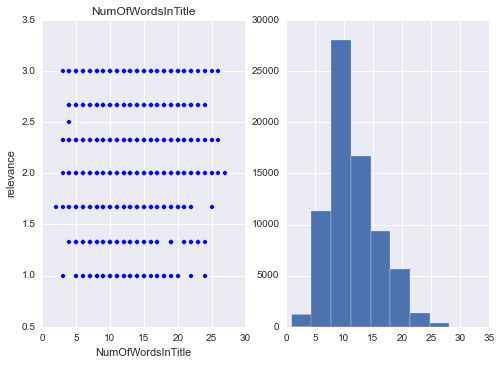

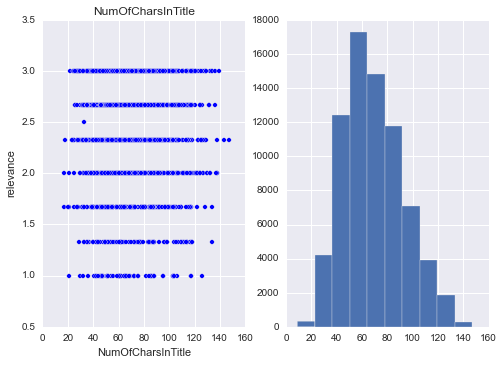

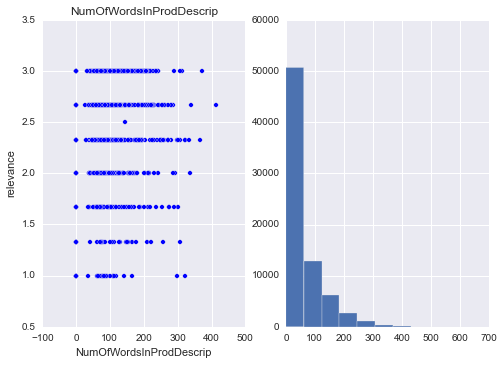

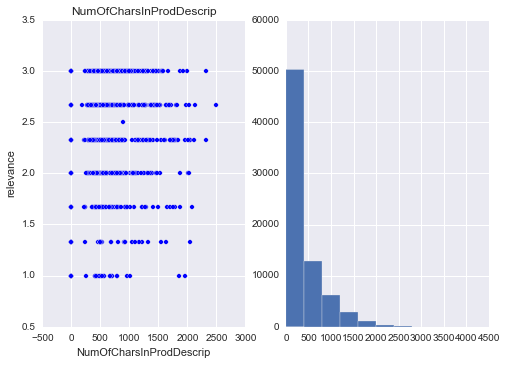

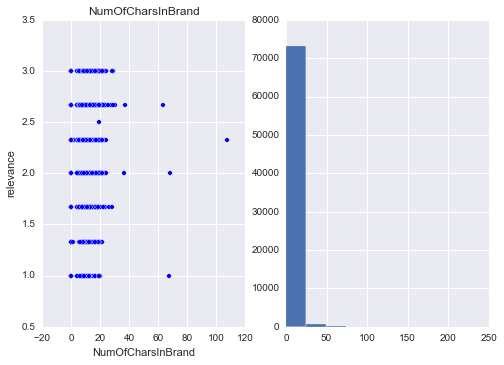

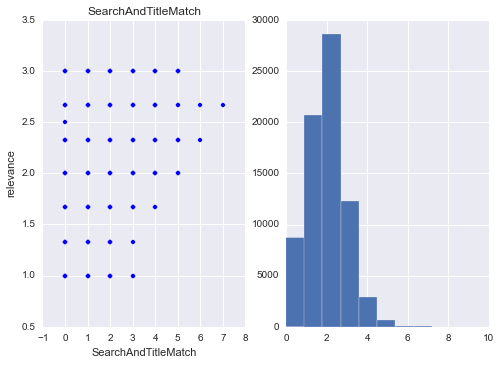

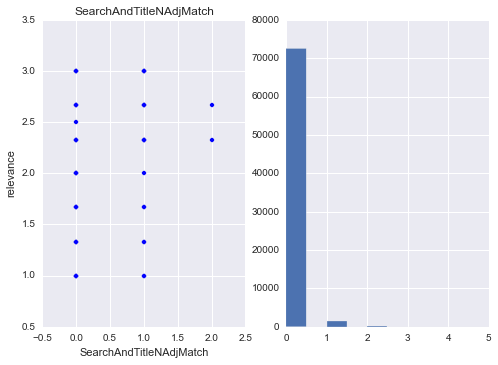

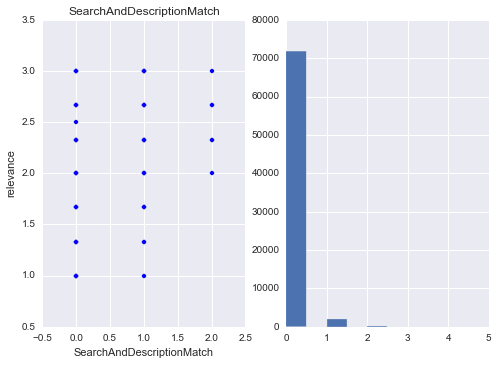

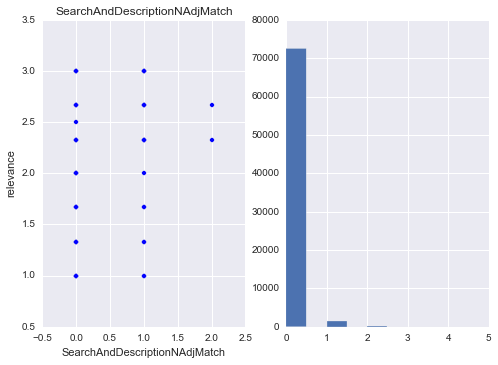

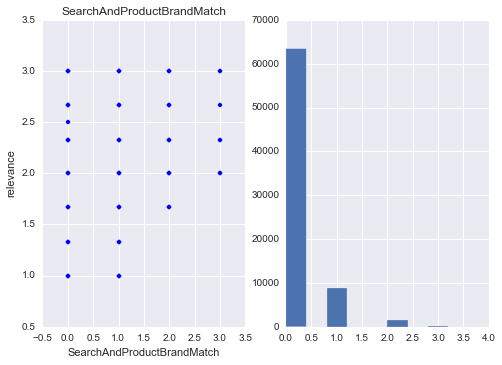

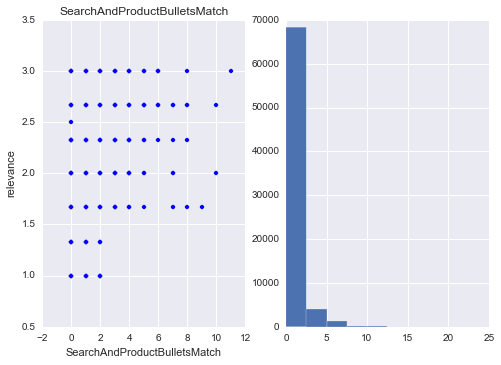

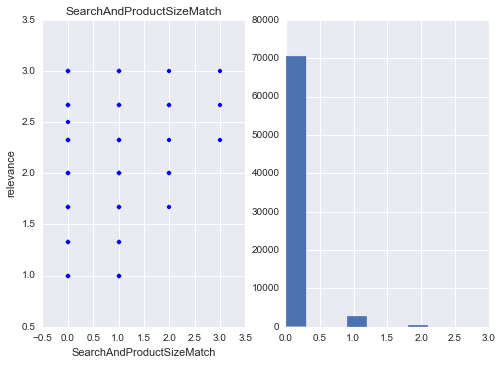

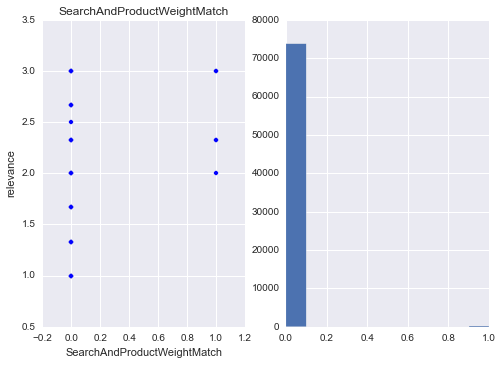

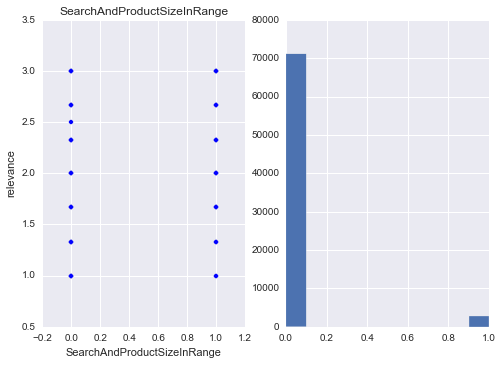

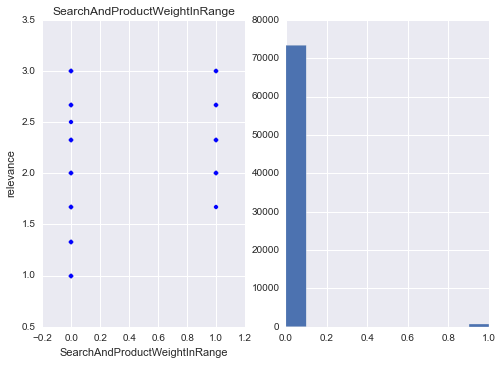

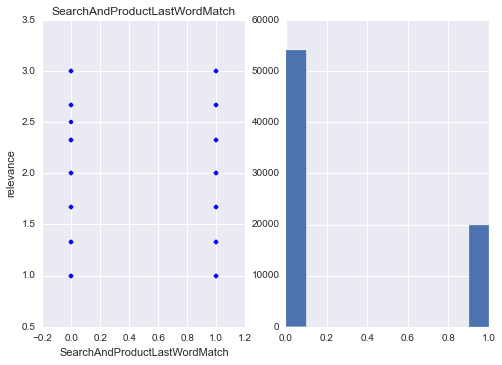

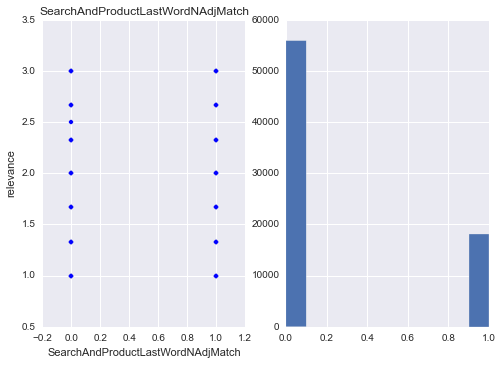

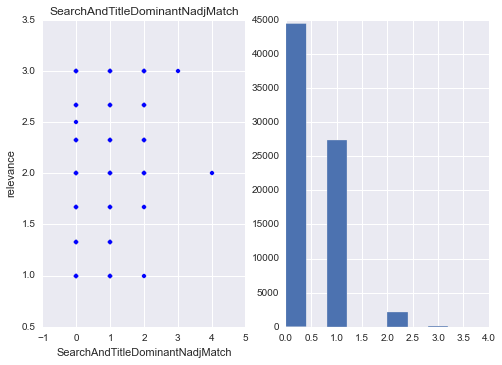

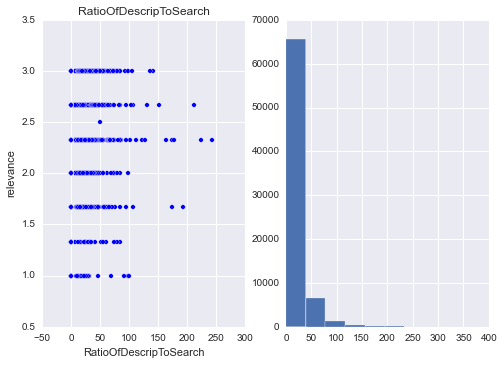

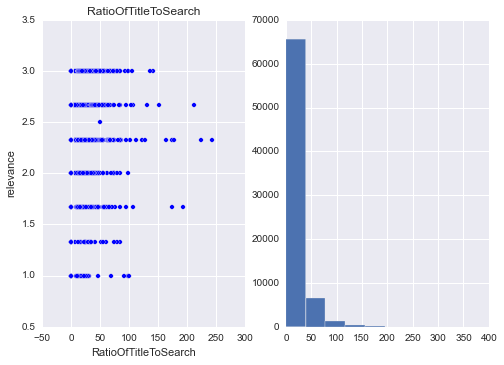

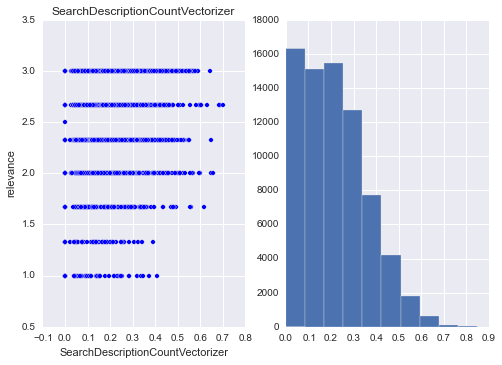

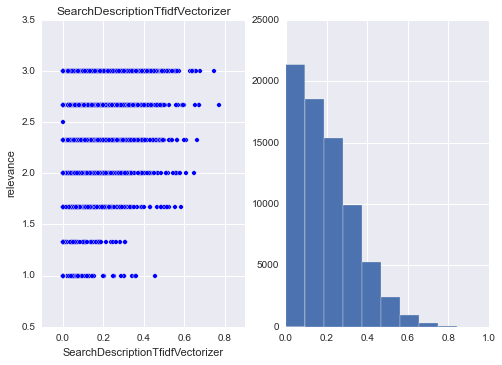

In [63]:
for f in feat_cols:
    plt.figure()
    plt.subplot(121)
    plt.scatter(df_train[f], df_train[Y_KEY])
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel(Y_KEY)
    plt.subplot(122)
    plt.hist(df_train[f])

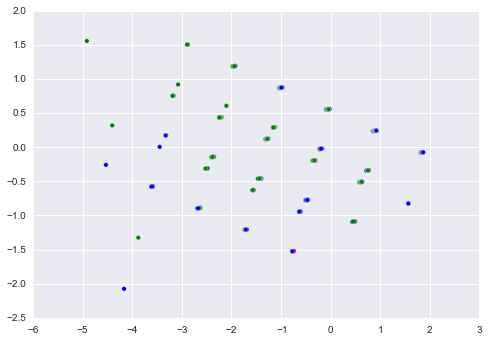

In [68]:
from sklearn.lda import LDA
from sklearn.decomposition import TruncatedSVD,PCA

lda = LDA()
svd = TruncatedSVD(n_components=2)
pca = PCA(n_components=2)
X, Y = feature_selection(df_train, feat_cols, Y_KEY)
Y = np.round(Y) - 1
X = pca.fit_transform(X,Y)

colors=['red', 'blue', 'green']
plt.scatter(X[:,0], X[:,1], c = map(lambda x: colors[int(x)], Y))

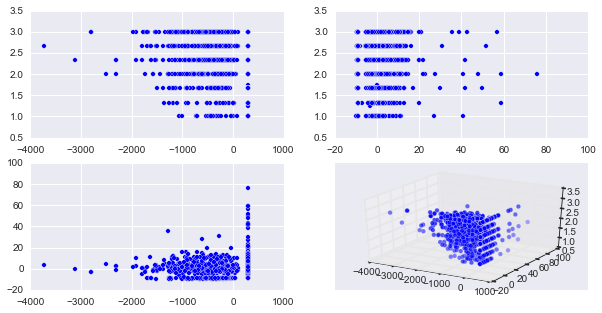

In [33]:
from mpl_toolkits.mplot3d import Axes3D
def decomp_scatter_3d(X, Y, decomp):
    args = [Y]
    X_decomp = decomp.fit_transform(X,*args)
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(221)
    ax.scatter(X_decomp[:,0], Y)
    ax = fig.add_subplot(222)    
    ax.scatter(X_decomp[:,1], Y)
    ax = fig.add_subplot(223)    
    ax.scatter(X_decomp[:,0], X_decomp[:,1])
    
    
    ax = fig.add_subplot(224, projection='3d')
    ax.scatter(X_decomp[:,0], X_decomp[:,1], Y)
X_min  = SelectKBest(f_regression, k = 10).fit_transform(df_train[feat_cols], df_train[Y_KEY])

decomp_scatter_3d(X_min,df_train[Y_KEY], pca)

# Gradient Boosting Regression

In [64]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', GradientBoostingRegressor())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
    'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_boost = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_boost.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 jobs       | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 200 jobs       | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 262 out of 270 | elapsed:    8.6s remaining:    0.3s
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:    9.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'clf__n_estimators': [20, 30, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x1215d0cf8>, verbose=1)

In [65]:
gs_boost.best_score_

-0.48759157125251429

In [66]:
gs_boost.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=20, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [67]:
apse_k_fold([gs_boost.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.484053,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 50,...",0.447464
1,0.498818,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 100...",0.442061


In [72]:
gs_boost.grid_scores_

[mean: -0.50719, std: 0.01302, params: {'kbest__k': 5, 'clf__n_estimators': 20},
 mean: -0.50738, std: 0.01296, params: {'kbest__k': 6, 'clf__n_estimators': 20},
 mean: -0.50119, std: 0.00478, params: {'kbest__k': 7, 'clf__n_estimators': 20},
 mean: -0.49356, std: 0.01183, params: {'kbest__k': 8, 'clf__n_estimators': 20},
 mean: -0.49371, std: 0.01175, params: {'kbest__k': 9, 'clf__n_estimators': 20},
 mean: -0.49368, std: 0.01171, params: {'kbest__k': 10, 'clf__n_estimators': 20},
 mean: -0.48551, std: 0.01202, params: {'kbest__k': 11, 'clf__n_estimators': 20},
 mean: -0.48565, std: 0.01233, params: {'kbest__k': 12, 'clf__n_estimators': 20},
 mean: -0.48318, std: 0.01412, params: {'kbest__k': 13, 'clf__n_estimators': 20},
 mean: -0.48352, std: 0.01474, params: {'kbest__k': 14, 'clf__n_estimators': 20},
 mean: -0.48365, std: 0.01463, params: {'kbest__k': 15, 'clf__n_estimators': 20},
 mean: -0.48357, std: 0.01456, params: {'kbest__k': 16, 'clf__n_estimators': 20},
 mean: -0.48402, std:

In [24]:
best_estimator = gs_boost.best_estimator_

# Neurel Net

In [39]:
from sklearn.neural_network import BernoulliRBM

In [50]:

steps = [('rbm', BernoulliRBM()),
        ('clf', LinearRegression())]
pipeline = Pipeline(steps)
apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY])

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.532333,Pipeline,"{u'rbm__verbose': 0, u'clf': LinearRegression(...",0.531907


In [56]:
ra = pipeline.steps[0][1]

# Linear Regression

In [46]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', LinearRegression())]
params = {
    'kbest__k' : list(xrange(5,len(feat_cols)-1)),
#     'kbest__k' : [21,22],
#     'clf__n_estimators' : [20, 30, 50, 75, 100],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_lm = GridSearchCV(pipeline, params, n_jobs=5, verbose=1, scoring=rmse_score)
gs_lm.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  46 out of  54 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x114bc0cf8>)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=5,
       param_grid={'kbest__k': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x119291f50>, verbose=1)

In [49]:
gs_lm.grid_scores_

[mean: -0.50562, std: 0.01287, params: {'kbest__k': 5},
 mean: -0.50532, std: 0.01299, params: {'kbest__k': 6},
 mean: -0.50577, std: 0.01266, params: {'kbest__k': 7},
 mean: -0.50372, std: 0.01413, params: {'kbest__k': 8},
 mean: -0.50076, std: 0.01615, params: {'kbest__k': 9},
 mean: -0.49985, std: 0.01650, params: {'kbest__k': 10},
 mean: -0.50053, std: 0.01608, params: {'kbest__k': 11},
 mean: -0.49692, std: 0.01180, params: {'kbest__k': 12},
 mean: -0.49741, std: 0.01248, params: {'kbest__k': 13},
 mean: -0.49437, std: 0.01403, params: {'kbest__k': 14},
 mean: -0.49429, std: 0.01373, params: {'kbest__k': 15},
 mean: -0.49411, std: 0.01383, params: {'kbest__k': 16},
 mean: -0.49413, std: 0.01391, params: {'kbest__k': 17},
 mean: -0.49369, std: 0.01405, params: {'kbest__k': 18},
 mean: -0.49356, std: 0.01414, params: {'kbest__k': 19},
 mean: -0.49346, std: 0.01421, params: {'kbest__k': 20},
 mean: -0.49381, std: 0.01373, params: {'kbest__k': 21},
 mean: -0.49367, std: 0.01377, param

In [47]:
apse_k_fold([gs_lm.best_estimator_,pipeline], df_train[feat_cols], df_train[Y_KEY])

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.492822,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.487029
1,0.502299,Pipeline,"{u'clf': LinearRegression(copy_X=True, fit_int...",0.496936


# Support Vector Regressor

Is super slow :(

In [ ]:
# steps = [('kbest', SelectKBest(f_regression)),
#         ('clf', SVR())]
# params = {
#     'kbest__k' : list(xrange(5,len(feat_cols)-1)),
# #     'kbest__k' : [21,22],
#     'clf__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
# }
# pipeline = Pipeline(steps)
# from sklearn.grid_search import GridSearchCV
# gs_svr = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1, scoring=rmse_score)
# gs_svr.fit(df_train[feat_cols], df_train[Y_KEY])
# # apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


Fitting 3 folds for each of 90 candidates, totalling 270 fits


# Random Forest

In [17]:
steps = [('kbest', SelectKBest(f_regression)),
        ('clf', RandomForestRegressor())]
params = {
    'kbest__k' : list(xrange(20,len(feat_cols)-1)),
    'clf__n_estimators' : [30],
}
pipeline = Pipeline(steps)
from sklearn.grid_search import GridSearchCV
gs_rf = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1, scoring=rmse_score)
gs_rf.fit(df_train[feat_cols], df_train[Y_KEY])
# apse_k_fold([pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x10e8d8cf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kbest__k': [20, 21, 22], 'clf__n_estimators': [30]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=<function rmse_score at 0x111851f50>, verbose=1)

In [18]:
gs_rf.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=22, score_func=<function f_regression at 0x10e8d8cf8>)), ('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [20]:
gs_rf.best_score_

-0.50913775501071679

In [21]:
apse_k_fold([gs_rf.best_estimator_, pipeline], df_train[feat_cols], df_train[Y_KEY], feature_selection=feature_selection)

(2000, 24)


,apse_mean,classifier,params,var_mean
0,0.510839,Pipeline,"{u'clf__n_estimators': 30, u'clf__warm_start':...",0.196107
1,0.544321,Pipeline,"{u'clf__n_estimators': 10, u'clf__warm_start':...",0.251904


In [22]:
gs_rf.grid_scores_

[mean: -0.51372, std: 0.00454, params: {'kbest__k': 20, 'clf__n_estimators': 30},
 mean: -0.51030, std: 0.00262, params: {'kbest__k': 21, 'clf__n_estimators': 30},
 mean: -0.50914, std: 0.00247, params: {'kbest__k': 22, 'clf__n_estimators': 30}]

# Make a Submission

In [45]:
apse_k_fold([best_estimator],
           df_train_full[feat_cols],
           df_train_full[Y_KEY]
           )

(74067, 24)


,apse_mean,classifier,params,var_mean
0,0.487941,Pipeline,"{u'clf__init': None, u'clf__n_estimators': 30,...",0.485822


In [46]:

best_estimator.fit(df_train_full[feat_cols], df_train_full[Y_KEY])

Pipeline(steps=[('kbest', SelectKBest(k=22, score_func=<function f_regression at 0x10e8d8cf8>)), ('clf', GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])

In [47]:
df_test = pd.read_csv('../data/test_features/test_features_full.csv')

In [48]:
y_test = best_estimator.predict(df_test[feat_cols])

(array([  56.,   90.,    0.,  187.,    0.,  314.,  408.,    2.,  426.,  517.]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <a list of 10 Patch objects>)

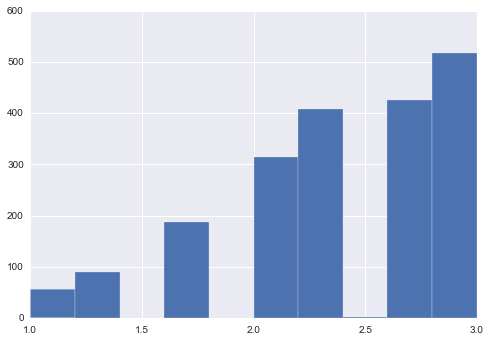

In [49]:
plt.hist(np.power(df_train[Y_KEY],1))

(array([   863.,   3945.,   8777.,  20619.,  27535.,  30208.,  30232.,
         23026.,  16782.,   4706.]),
 array([ 1.85424446,  1.94769979,  2.04115511,  2.13461044,  2.22806576,
         2.32152108,  2.41497641,  2.50843173,  2.60188706,  2.69534238,
         2.78879771]),
 <a list of 10 Patch objects>)

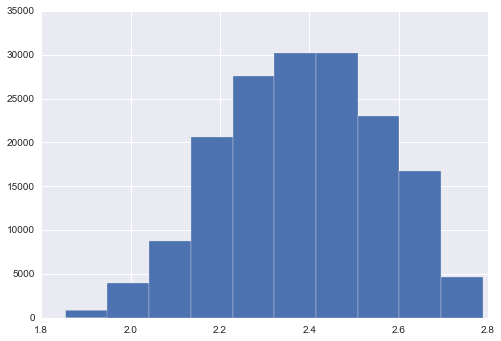

In [50]:
plt.hist(y_test)

In [51]:
df_test_submission = pd.DataFrame(dict(id = df_test['id'], relevance=y_test))

In [52]:
df_test_submission.to_csv('submission.csv', index=False)

In [53]:
df_test_raw = pd.read_csv('../data/test.csv')

In [42]:
df_test_joined = pd.read_csv('../data/test_joined.csv')

In [43]:
ids_a = set(df_test_joined['id'].tolist())
ids_b = set(df_test_raw['id'].tolist())

In [44]:
ids_a.difference(ids_b)

set()